# Démo : Visualisation de données multidimensionnelles et réduction de variables

Dans ce cours nous allons réaliser une analyse de données d’expression de gènes dans le cancer du sein à l'aide des méthodes non supervisées en machine learning : ACP, t-SNE et UMAP. Ces méthodes sont souvent utilisées pour projeter les données multidimensionnelles en 2 ou 3 dimensions, pour pouvoir les visualiser. Elles peuvent également servir pour réduire le nombre de variables, décorréler les variables et supprimer le bruit.

Nous allons utiliser les données réelles d’expression de gènes dans le cancer du sein (données de séquençage du génome humain RNA-seq) issues de la base de données publique TCGA-BRCA https://portal.gdc.cancer.gov/. Les données ont été préalablement prétraitées : alignées, normalisées selon la méthode FPKM et log-transformées $log_2$(1+FPKM). Elles sont prêtes pour l’analyse. 

# 1. Importer les données

Les données sont disponibles dans le fichier `breast_cancer.csv` dans le répertoire `data`. L'import de données se fait avec la commande `read_csv` de la librairie **pandas**. L'attribut `shape` contient les dimensions de la matrice de données (dataframe).

In [1]:
import pandas as pd

data = pd.read_csv('../data/breast_cancer.csv', sep=';', index_col='id_sample')
print('data', data.shape)

data (1016, 51)


Le dataframe `data` contient 1016 lignes et 51 colonnes.

La méthode `head()` permet d'afficher les 5 premières lignes du dataframe.

In [2]:
data.head()

,NAT1,BIRC5,BAG1,BCL2,BLVRA,CCNB1,CCNE1,CDC6,CDC20,CDH3,...,GPR160,UBE2T,CXXC5,ANLN,CEP55,ACTR3B,MLPH,NUF2,TMEM45B,pam50
id_sample,,,,,,,,,,,,,,,,,,,,,
TCGA-3C-AAAU-01A,7.100449,3.361004,3.972581,4.145669,4.765233,4.788987,2.164814,2.633598,4.131205,0.133455,...,4.150233,4.106918,5.528618,3.073409,2.669860,1.928460,5.567999,2.536764,0.213597,luminal-A
TCGA-3C-AALI-01A,3.453640,4.501040,2.720929,1.493020,5.823480,5.281003,2.535437,2.734157,4.176553,0.110023,...,5.561226,5.648057,4.711309,3.881110,3.357553,1.168684,7.064176,3.124620,3.946538,HER2-enriched
TCGA-3C-AALJ-01A,4.455574,4.164643,3.911511,4.191457,5.987255,5.229446,2.267963,3.379961,4.592752,0.236786,...,2.859309,5.213461,6.152875,2.697093,2.599436,1.177678,5.222420,3.053335,0.281303,luminal-B
TCGA-3C-AALK-01A,4.297961,3.920234,3.688335,3.894904,5.211594,4.014641,0.951107,1.472950,3.806552,0.062392,...,3.063807,4.166154,5.612184,2.645664,2.448027,1.026535,6.225590,1.717959,3.289543,luminal-A
TCGA-4H-AAAK-01A,1.695378,2.950846,4.110014,3.572843,4.317856,3.772768,1.103958,2.338953,3.473484,0.098773,...,3.289418,3.437585,4.299617,2.068516,2.152652,1.513181,5.485277,1.537125,2.976903,luminal-A


Le dataframe contient les niveaux d’expression de 50 gènes (NAT1, BIRC5, BAG1, etc.) dans différents échantillons (effectif total n=1016). La dernière colonne nommée **pam50** contient le sous-type moléculaire du cancer du sein, mesuré pour chaque échantillon. Quatre sous-types moléculaires sont disponibles : **luminal-A**, **luminal-B**, **HER2-enriched** et **basal-like**. Le cancer du sein de type *luminal-A* a généralement un bon pronostic pour les patients. En revanche, le cancer du sein de type *basal-like* a souvent un pronostic sombre. 

On peut afficher le nombre d'échantillons dans chaque sous-type moléculaire en utilisant la méthode `groupby` de pandas.

In [3]:
data.groupby(['pam50']).size()

pam50
HER2-enriched     82
basal-like       190
luminal-A        543
luminal-B        201
dtype: int64

<AxesSubplot:xlabel='pam50'>

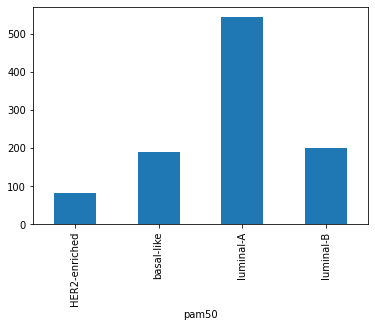

In [4]:
data.groupby(['pam50']).size().plot(kind = "bar")

On peut remarquer que les données ne sont pas distribuées de la façon homogène selon le type de cancer. En effet, le cancer du sein de type *luminal-A* survient plus fréquemment dans la population générale par rapport aux autres sous-types moléculaires de ce cancer.

# 2. Séparer les données d’expression et les étiquettes

Pour réaliser le calcul sur les données d’expression, il nous sera plus pratique de séparer les valeurs numériques des expressions de gènes et les étiquettes des sous-types moléculaires *pam50* dans deux objets différents.

En suivant la nomenclature standard acceptée dans `scikit-learn`, on nommera **X** la matrice de données d’expression et **y** les étiquettes correspondantes.

In [5]:
# Données d'expression de 50 gènes
X = data.select_dtypes('number') 
print('X', X.shape)

X (1016, 50)


In [6]:
# Etiquettes correspondantes (sous-types moléculaires)
y = data['pam50']
print('y', y.shape)

y (1016,)


# 3. Afficher les valeurs d'expression

Le code suivant permet d'afficher les valeurs d'expression pour chaque gène, rangées par les moyennes.

<AxesSubplot:ylabel='Expression'>

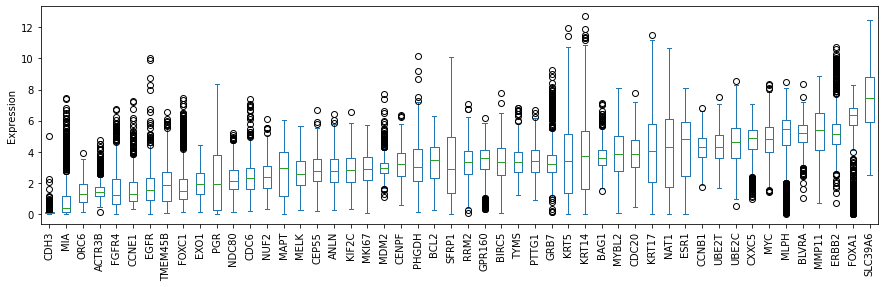

In [7]:
sort_by_mean = X.mean().sort_values(ascending=True)
X[sort_by_mean.index].plot(kind='box', figsize=(15, 4), rot=90, ylabel='Expression')

Pour certains gènes les niveaux d’expression varient beaucoup, pour d’autres non. Les plages de valeurs sont différentes d’un gène à l’autre. Cette situation peut impacter fortement l’analyse en composantes principales (ACP) qui est principalement basée sur la variance. Les gènes avec une forte variance absolue auront plus de poids dans l’analyse que ceux avec une faible variance. Pour cette raison, **les données doivent être obligatoirement normalisées (standardisées)** avant l’analyse.

# 4. Appliquer une normalisation centrée-réduite aux données 

La normalisation (standardisation) centrée-réduite consiste à soustraire la moyenne et à diviser par l'écart-type les valeurs d'expression. On peut la réaliser avec l’objet `StandardScaler` de la librairie `scikit-learn`.

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # instanciation de l'objet scaler
X_scaled = scaler.fit_transform(X) # normalisation centrée-réduite
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns) # conversion du résultat en objet dataframe de pandas

Les valeurs d'expression sont ramenées à la même échelle après une normalisation centrée-réduite. La moyenne d’expression de chaque gène est égale à 0 et l'écart type est égal à 1.

<AxesSubplot:ylabel='Expression'>

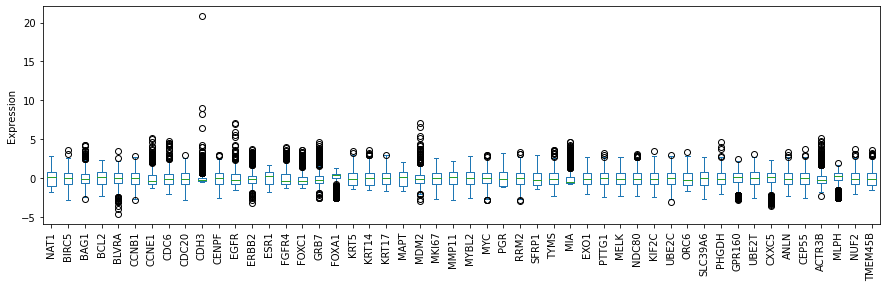

In [9]:
X_scaled.plot(kind='box', figsize=(15, 4), rot=90, ylabel='Expression')

# 5. Faire une analyse en composantes principales (ACP)

Le calcul de l'ACP peut se faire à l'aide de l'objet `PCA` de `scikit-learn`.

In [10]:
from sklearn.decomposition import PCA

## 5.1  Calcul de l'ACP

Pour calculer une ACP, on utilise les données standardisées **X_scaled**.

In [11]:
pca = PCA() # instanciation de l'objet pca
X_pca = pca.fit_transform(X_scaled) # réalisation de l'ACP sur les données X_scaled

Il est plus pratique de convertir le résultat de l'ACP **X_pca** en dataframe pandas, en précisant les noms de colonnes : de *PC1* à *PC50*. 

In [12]:
# Conversion en dataframe pandas
pca_columns = ['PC' + str(c) for c in range(1, X_pca.shape[1]+1, 1)] # création d'une liste avec les noms de colonnes de PC1 à PC50
X_pca = pd.DataFrame(X_pca, index=X.index, columns=pca_columns) # création du dataframe
X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
id_sample,,,,,,,,,,,,,,,,,,,,,
TCGA-3C-AAAU-01A,-0.826271,-3.433650,-2.510632,0.738305,-1.069998,-0.526869,0.826776,1.402600,-0.712689,-1.873343,...,-0.294489,-0.239547,0.079559,-0.104298,-0.378077,0.083779,-0.163103,0.172791,0.028911,0.017975
TCGA-3C-AALI-01A,2.902839,-3.922170,6.698382,-1.531670,-0.138620,-0.431154,0.519937,-0.732733,-0.720277,-0.500913,...,-0.012068,0.320612,0.340675,0.188449,-0.423823,0.002814,-0.493395,0.676903,-0.099423,0.227992
TCGA-3C-AALJ-01A,0.869263,-3.749200,-0.434459,0.689772,1.928451,-0.534292,-0.280851,1.430496,-0.582105,-0.381386,...,0.001786,-0.225937,0.140912,-0.055719,-0.039554,-0.188600,-0.085266,0.329374,-0.467050,0.271044
TCGA-3C-AALK-01A,-1.765921,0.760450,1.339832,-2.331983,0.074528,0.138779,-0.411600,0.352907,0.126035,0.530383,...,0.122736,-0.214867,0.415538,0.085572,0.213560,-0.346038,0.108832,-0.087644,-0.019231,-0.172559
TCGA-4H-AAAK-01A,-2.017120,1.740945,1.163439,-1.385725,0.171750,-0.465903,-2.096529,1.139202,1.572573,-0.886130,...,-0.084215,0.077875,0.005870,0.045677,0.005480,-0.185906,-0.033933,-0.050316,0.082190,0.107746


## 5.2 Calcul de la variance expliquée

Les valeurs de la variance expliquée par composante sont disponibles dans l’attribut `pca.explained_variance_ratio_` après le calcul de l'ACP.

In [13]:
pca.explained_variance_ratio_

array([0.4141211 , 0.1399058 , 0.06153661, 0.04304336, 0.03228112,
       0.02948981, 0.02137533, 0.01932914, 0.01927726, 0.01648891,
       0.01537033, 0.01345515, 0.01179742, 0.01091564, 0.01032152,
       0.00954922, 0.00895897, 0.00852771, 0.00772808, 0.00720844,
       0.00692966, 0.00656934, 0.0064256 , 0.00572167, 0.00549796,
       0.00520188, 0.00488695, 0.004677  , 0.00435519, 0.00405197,
       0.00376135, 0.00360729, 0.00322888, 0.00311163, 0.00295957,
       0.00278843, 0.00275436, 0.0025318 , 0.00243809, 0.00232694,
       0.00216209, 0.00200786, 0.00189123, 0.00173565, 0.00162586,
       0.001574  , 0.00132835, 0.00118083, 0.00108477, 0.00090288])

On peut les convertir en objet `Series` de pandas et présenter les valeurs en pourcentage.

In [14]:
explained_variance = pd.Series(dict(zip(X_pca.columns, 100.0*pca.explained_variance_ratio_)))
print(explained_variance.head())

PC1    41.412110
PC2    13.990580
PC3     6.153661
PC4     4.304336
PC5     3.228112
dtype: float64


<AxesSubplot:ylabel='Explained variance'>

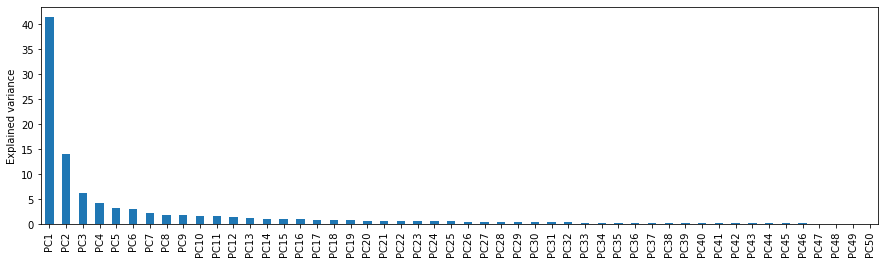

In [15]:
explained_variance.plot(kind='bar', figsize=(15, 4), rot=90, ylabel='Explained variance')

In [16]:
explained_variance['PC1'] + explained_variance['PC2']

55.4026895475862

Les deux premières composantes de l'ACP expliquent **55.4%** de la variance. 

In [17]:
explained_variance['PC1'] + explained_variance['PC2'] + explained_variance['PC3']

61.556350746238905

Les trois premières composantes de l'ACP expliquent **61.6%** de la variance.

## 5.3 Visualisation des deux premières composantes principales de l’ACP

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

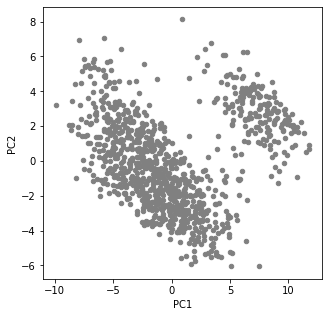

In [18]:
X_pca.plot(x='PC1', y='PC2', kind='scatter', figsize=(5, 5), color='gray')

Les points se rassemblent naturellement en clusters, notamment deux clusters sont nettement visibles. Présentons chaque sous-type moléculaire en différente couleur pour comprendre à quoi correspondent ces clusters.

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

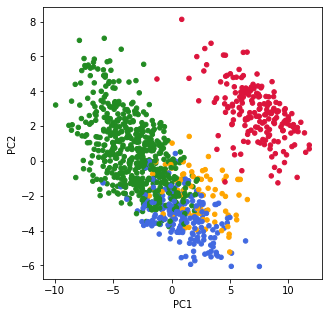

In [19]:
dict_colors = {'luminal-A': 'forestgreen', 'luminal-B': 'royalblue', 'HER2-enriched': 'orange', 'basal-like': 'crimson'} 
y_colors = [dict_colors[yi] for yi in y]
X_pca.plot(x='PC1', y='PC2', kind='scatter', figsize=(5, 5), color=y_colors)

## 5.4 Visualisation des trois premières composantes principales de l’ACP

Pour créer une image en 3D, on utilisera la librairie standard `matplotlib` de Python.

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

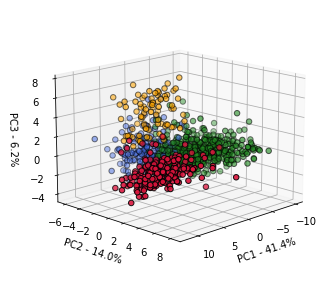

In [21]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_pca['PC1'], X_pca['PC2'], X_pca['PC3'], marker='o', s=30, edgecolor='k', facecolor=y_colors)
ax.set_xlabel('PC1 - ' + '{:.1f}%'.format(explained_variance['PC1']))
ax.set_ylabel('PC2 - ' + '{:.1f}%'.format(explained_variance['PC2']))
ax.set_zlabel('PC3 - ' + '{:.1f}%'.format(explained_variance['PC3']))
ax.view_init(elev=15, azim=45)

# 6. Visualiser les données avec la méthode t-SNE

La méthode **t-SNE** (t-distributed stochastic neighbor embedding) fait partie de la librairie `scikit-learn`.

In [22]:
from sklearn.manifold import TSNE

## 6.1 Projection 2D

In [23]:
tsne = TSNE(n_components=2, init='pca', random_state=0, n_jobs=-1)
X_tsne = tsne.fit_transform(X_scaled)

In [24]:
columns = ['DIM' + str(c) for c in range(1, X_tsne.shape[1]+1, 1)]
X_tsne = pd.DataFrame(X_tsne, index=X.index, columns=columns)
X_tsne.head()

,DIM1,DIM2
id_sample,,
TCGA-3C-AAAU-01A,-2.491290,2.128492
TCGA-3C-AALI-01A,16.860023,-30.949909
TCGA-3C-AALJ-01A,4.572213,-3.260185
TCGA-3C-AALK-01A,-20.486006,-15.297353
TCGA-4H-AAAK-01A,-22.056263,-14.502122


<AxesSubplot:xlabel='DIM1', ylabel='DIM2'>

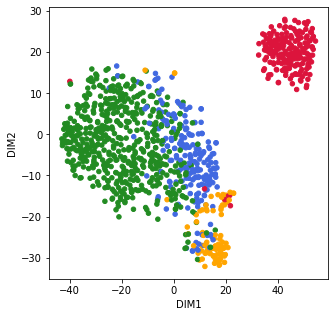

In [25]:
X_tsne.plot(x='DIM1', y='DIM2', kind='scatter', figsize=(5, 5), color=y_colors)

In [26]:
# La divergence de Kullback-Leibler après optimisation
tsne.kl_divergence_

1.2237257957458496

## 6.2 Projection 3D

In [27]:
tsne = TSNE(n_components=3, init='pca', perplexity=45, random_state=0, n_jobs=-1)
X_tsne = tsne.fit_transform(X_scaled)

In [28]:
columns = ['DIM' + str(c) for c in range(1, X_tsne.shape[1]+1, 1)]
X_tsne = pd.DataFrame(X_tsne, index=X.index, columns=columns)
X_tsne.head()

,DIM1,DIM2,DIM3
id_sample,,,
TCGA-3C-AAAU-01A,-21.247744,-52.921299,27.287085
TCGA-3C-AALI-01A,55.304852,-17.427996,46.623470
TCGA-3C-AALJ-01A,26.139465,-35.513199,-25.104609
TCGA-3C-AALK-01A,-5.840808,19.576532,37.464130
TCGA-4H-AAAK-01A,-12.005431,24.309347,28.881147


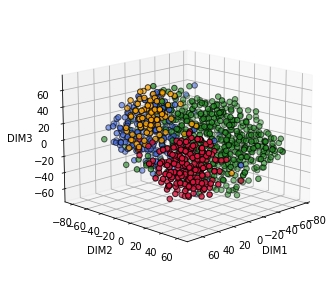

In [29]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_tsne['DIM1'], X_tsne['DIM2'], X_tsne['DIM3'], marker='o', s=30, edgecolor='k', facecolor=y_colors)
ax.set_xlabel('DIM1')
ax.set_ylabel('DIM2')
ax.set_zlabel('DIM3')
ax.view_init(elev=15, azim=45)

In [30]:
tsne.kl_divergence_

1.1111326217651367

# 7. Visualiser les données avec la méthode UMAP

Actuellement, la méthode **UMAP** (Uniform Manifold Approximation and Projection) n’est pas intégrée dans `scikit-learn`. Pour l’utiliser il est nécessaire d’installer la librairie `umap-learn` (voir doc https://umap-learn.readthedocs.io). La commande d’installation avec *pip*  est `pip install umap-learn`.

In [31]:
import umap

## 7.1 Projection 2D

In [32]:
embedding = umap.UMAP(n_components=2, random_state=0, n_jobs=-1)
X_umap = embedding.fit_transform(X_scaled)
columns = ['DIM' + str(c) for c in range(1, X_umap.shape[1]+1, 1)]
X_umap = pd.DataFrame(X_umap, index=X.index, columns=columns)

<AxesSubplot:xlabel='DIM1', ylabel='DIM2'>

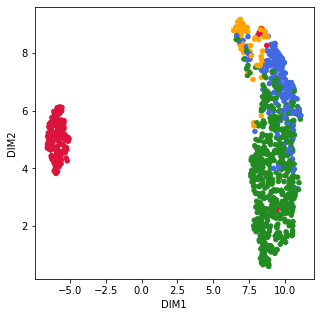

In [33]:
X_umap.plot(x='DIM1', y='DIM2', kind='scatter', figsize=(5, 5), color=y_colors)

## 7.2 Projection 3D

In [34]:
embedding = umap.UMAP(n_components=3, random_state=0, n_jobs=-1)
X_umap = embedding.fit_transform(X_scaled)
columns = ['DIM' + str(c) for c in range(1, X_umap.shape[1]+1, 1)]
X_umap = pd.DataFrame(X_umap, index=X.index, columns=columns)

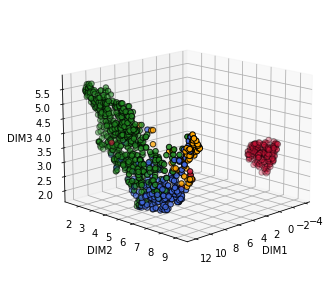

In [35]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_umap['DIM1'], X_umap['DIM2'], X_umap['DIM3'], marker='o', s=30, edgecolor='k', facecolor=y_colors)
ax.set_xlabel('DIM1')
ax.set_ylabel('DIM2')
ax.set_zlabel('DIM3')
ax.view_init(elev=15, azim=45)